In [1]:
import os
from datetime import datetime, timedelta
import quandl
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

$$ 1. Data Preperation (RTH vs. XRT)

In [2]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(os.environ.get("HOME", os.environ["USERPROFILE"]), "quandl_data_table_downloads")
    data_latest = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    
    if avoid_download and os.path.exists(data_latest):
        print(f"Skipping any possible download of {table_path}")
        return data_latest
    
    table_dir = os.path.dirname(data_latest)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.makedirs(table_dir, exist_ok=True)

    if date_override is None:
        my_date = datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
            os.remove(data_file)
        else:
            print(f"Data file {data_file} size {file_size} exists already, no need to download")
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key='6cwMvypxWuUzBWyGbMFC', **kwargs
    )
    
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_latest):
                print(f"Removing old latest file")
                os.remove(data_latest)
            print(f"Creating copy: {data_file} -> {data_latest}")
            shutil.copy2(data_file, data_latest)
    else:
        print(f"Data file {data_file} failed download")
        return None
    
    return data_latest if (date_override is None or allow_old_file) else "NoFileAvailable"

def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    file_path = grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    if file_path:
        return pd.read_csv(file_path)
    return None


In [3]:
# Fetch data
try:
    data = fetch_quandl_table('QUOTEMEDIA/PRICES', avoid_download=False)
    if data is not None:
        print(data.head())
    else:
        print("Failed to fetch data")
except Exception as e:
    print(f"Error occurred: {str(e)}")

Download finished: 1667403863 bytes
Removing old latest file
Creating copy: C:\Users\steph\quandl_data_table_downloads\QUOTEMEDIA/PRICES_20250122.zip -> C:\Users\steph\quandl_data_table_downloads\QUOTEMEDIA/PRICES_latest.zip
  ticker        date     open     high      low  close     volume  dividend  \
0  JTKWY  2022-03-11   6.1700   7.3200   5.7900   6.72  9440097.0       0.0   
1  JTKWY  2022-03-10   6.1600   6.1750   5.9350   6.07  2261623.0       0.0   
2   FG_1  2020-06-01   8.1000   8.3900   8.1000   8.39  3086317.0       0.0   
3  YTENQ  2024-09-30   0.9514   1.0500   0.9514   1.05      842.0       0.0   
4   FLWS  2022-03-09  14.5700  14.9588  14.4100  14.45   662492.0       0.0   

   split  adj_open  adj_high  adj_low  adj_close  adj_volume  
0    1.0    6.1700    7.3200   5.7900       6.72   9440097.0  
1    1.0    6.1600    6.1750   5.9350       6.07   2261623.0  
2    1.0    8.1000    8.3900   8.1000       8.39   3086317.0  
3    1.0    0.9514    1.0500   0.9514       1.05

In [4]:
start_date = '2022-12-02'
end_date = '2024-11-15'

#RTH
RTH = data[data['ticker'] == 'RTH'].copy()
RTH['date'] = pd.to_datetime(RTH['date'])

RTH.set_index('date', inplace=True)
RTH = RTH.sort_index()

RTH = RTH[start_date:end_date]

#XTR
XRT = data[data['ticker'] == 'XRT'].copy()
XRT['date'] = pd.to_datetime(XRT['date'])

XRT.set_index('date', inplace=True)
XRT = XRT.sort_index()

XRT = XRT[start_date:end_date]

#SVOL
SVOL = data[data['ticker'] == 'SVOL'].copy()
SVOL['date'] = pd.to_datetime(SVOL['date'])

SVOL.set_index('date', inplace=True)
SVOL = SVOL.sort_index()

SVOL = SVOL[start_date:end_date]


In [5]:
def load_ff_factors(file_path='F-F_Research_Data_Factors_daily.csv'):
    try:
        # Read the CSV file, skipping the first few rows of header information
        ff_data = pd.read_csv(
            file_path,
            skiprows=3,  # Skip header rows
            na_values=-99.99,  # Common NA value in FF data
            names=['date', 'Mkt-RF', 'SMB', 'HML', 'RF']  # Column names
        )
        
        ff_data = ff_data.iloc[1:-1]
        numeric_cols = ['Mkt-RF', 'SMB', 'HML', 'RF']
        for col in numeric_cols:
            ff_data[col] = pd.to_numeric(ff_data[col], errors='coerce')

        ff_data['date'] = pd.to_datetime(ff_data['date'], format='%Y%m%d')
        
        # Set date as index
        ff_data.set_index('date', inplace=True)
        
        return ff_data
    
    except Exception as e:
        print(f"Error loading Fama-French data: {str(e)}")
        return None
    
ff_factors = load_ff_factors()
ff_factors


,Mkt-RF,SMB,HML,RF
date,,,,
1926-07-01,0.10,-0.25,-0.27,0.009
1926-07-02,0.45,-0.33,-0.06,0.009
1926-07-06,0.17,0.30,-0.39,0.009
1926-07-07,0.09,-0.58,0.02,0.009
1926-07-08,0.21,-0.38,0.19,0.009
...,...,...,...,...
2024-11-22,0.54,1.25,0.41,0.020
2024-11-25,0.40,1.07,0.27,0.020
2024-11-26,0.42,-0.92,-0.71,0.020


$$ 2. Spread Trading Strategy

In [6]:
class SpreadTradingStrategy:
    def __init__(self, 
                 etf_x_data: pd.DataFrame,  # X=RTH ETF price data
                 etf_y_data: pd.DataFrame,  # Y=XRT ETF price data
                 lookback_M: int = 10,      # M-day return lookback
                 entry_g: float = 0.02,     # Entry threshold
                 exit_j: float = 0.01,      # Exit threshold
                 stop_loss_s: float = 0.1,  # Stop loss proportion
                 trade_cost_zeta: float = 0.00001):  # Trading cost
        
        self.etf_x = etf_x_data
        self.etf_y = etf_y_data
        self.M = lookback_M
        self.g = entry_g
        self.j = exit_j
        self.s = stop_loss_s
        self.zeta = trade_cost_zeta
        
        # Calculate Nt series (15-day median dollar volume for X)
        self.calculate_Nt()
        
        # Set capital K as maximum Nt * 2
        self.capital = self.Nt.max() * 2
        
        # Initialize tracking variables
        self.positions = []
        self.cumulative_pnl = 0
        self.current_position = None

    def calculate_Nt(self):
        """Calculate Nt as the running 15-day median dollar volume for the less liquid ETF"""
        # Calculate daily dollar volume for both ETFs
        dollar_volume_x = self.etf_x['adj_close'] * self.etf_x['adj_volume']
        dollar_volume_y = self.etf_y['adj_close'] * self.etf_y['adj_volume']
        
        # Determine which ETF is less liquid (based on average dollar volume)
        avg_volume_x = dollar_volume_x.mean()
        avg_volume_y = dollar_volume_y.mean()
        
        # Calculate the rolling median for the less liquid ETF
        if avg_volume_x < avg_volume_y:
            self.less_liquid_etf = 'RTH' #X
            self.Nt = dollar_volume_x.rolling(window=15).median()
        else:
            self.less_liquid_etf = 'XRT' #Y
            self.Nt = dollar_volume_y.rolling(window=15).median()
            
        print(f"ETF {self.less_liquid_etf} is less liquid and will be used for Nt calculations")

    def calculate_returns(self):
        """Calculate M-day returns for both ETFs"""
        x_returns = self.etf_x['adj_close'].pct_change(self.M)
        y_returns = self.etf_y['adj_close'].pct_change(self.M)
        return x_returns, y_returns

    def calculate_spread_difference(self, date):
        """Calculate spread difference z between M-day returns"""
        x_returns, y_returns = self.calculate_returns()
        return x_returns[date] - y_returns[date]

    def get_position_size(self, date):
        """Calculate position size as close to Nt/100 as possible"""
        if date not in self.Nt.index or pd.isna(self.Nt[date]):
            return 0, 0
        
        target_value = self.Nt[date] / 100
        
        # Calculate number of shares for each ETF
        if (pd.isna(self.etf_x.loc[date, 'adj_close']) or 
            pd.isna(self.etf_y.loc[date, 'adj_close'])):
            return 0, 0
        
        # Calculate number of shares for each ETF
        try:
            x_shares = round(target_value / self.etf_x.loc[date, 'adj_close'])
            y_shares = round(target_value / self.etf_y.loc[date, 'adj_close'])
            
            return x_shares, y_shares
        except:
            return 0, 0

    def execute_trade(self, date, spread_diff):
        """Execute trading logic for given date"""
        # Skip if we're in timeout period from stop loss
        if hasattr(self, 'timeout_until') and date <= self.timeout_until:
            return
            
        # Check stop loss if we have a position
        if self.current_position is not None:
            current_pnl = self.calculate_position_pnl(date)
            stop_loss_threshold = -self.s * self.current_position['gross_traded_cash']
            
            if current_pnl < stop_loss_threshold:
                # Hit stop loss - close position
                self.close_position(date, 'Stop Loss')
                # Set timeout until end of month
                self.timeout_until = date + pd.offsets.MonthEnd(0)
                return

        # Regular trading logic
        if self.current_position is None and abs(spread_diff) > self.g:
            # Open new position
            x_shares, y_shares = self.get_position_size(date)
            gross_value = (abs(x_shares * self.etf_x.loc[date, 'adj_close']) + 
                         abs(y_shares * self.etf_y.loc[date, 'adj_close']))
            
            # Short higher return ETF, long lower return ETF
            if spread_diff > 0:
                # X had higher return, so short X and long Y
                self.current_position = {
                    'entry_date': date,
                    'x_shares': -x_shares,  # Short X
                    'y_shares': y_shares,   # Long Y
                    'x_entry_price': self.etf_x.loc[date, 'adj_close'],
                    'y_entry_price': self.etf_y.loc[date, 'adj_close'],
                    'gross_traded_cash': gross_value,
                    'type': 'short_spread'
                }
            else:
                # Y had higher return, so short Y and long X
                self.current_position = {
                    'entry_date': date,
                    'x_shares': x_shares,   # Long X
                    'y_shares': -y_shares,  # Short Y
                    'x_entry_price': self.etf_x.loc[date, 'adj_close'],
                    'y_entry_price': self.etf_y.loc[date, 'adj_close'],
                    'gross_traded_cash': gross_value,
                    'type': 'long_spread'
                }
            
            # Apply entry trading costs
            self.current_position['entry_cost'] = gross_value * self.zeta
            
        elif self.current_position is not None and abs(spread_diff) < self.j:
            # Close position if spread difference is below exit threshold
            self.close_position(date, 'Target Exit')

    def calculate_position_pnl(self, date):
        """Calculate PnL for current position"""
        if self.current_position is None:
            return 0
            
        x_pnl = self.current_position['x_shares'] * (
            self.etf_x.loc[date, 'adj_close'] - self.current_position['x_entry_price']
        )
        y_pnl = self.current_position['y_shares'] * (
            self.etf_y.loc[date, 'adj_close'] - self.current_position['y_entry_price']
        )
        
        return x_pnl + y_pnl - self.current_position['entry_cost']

    def close_position(self, date, reason):
        """Close current position and record it"""
        if self.current_position is None:
            return
            
        # Calculate exit values
        exit_gross_value = (
            abs(self.current_position['x_shares'] * self.etf_x.loc[date, 'adj_close']) +
            abs(self.current_position['y_shares'] * self.etf_y.loc[date, 'adj_close'])
        )
        
        # Calculate final PnL including all costs
        final_pnl = self.calculate_position_pnl(date) - (exit_gross_value * self.zeta)
        self.cumulative_pnl += final_pnl

        # Record the trade
        self.positions.append({
            'entry_date': self.current_position['entry_date'],
            'exit_date': date,
            'pnl': final_pnl,
            'type': self.current_position['type'],
            'exit_reason': reason,
            'gross_traded_value': self.current_position['gross_traded_cash']
        })
        
        self.current_position = None

    def run_strategy(self, start_date='2023-01-01', end_date='2024-11-15'):
        """Run the complete trading strategy"""
        
        self.etf_x = self.etf_x.sort_index()
        self.etf_y = self.etf_y.sort_index()
        self.Nt = self.Nt.sort_index()
        
        # Filter directly using loc with string dates
        date_range = self.etf_x.loc[start_date:end_date].index
        
        for date in date_range:
            spread_diff = self.calculate_spread_difference(date)
            if pd.notnull(spread_diff):
                self.execute_trade(date, spread_diff)
        
        # Force close any remaining position at end of period
        if self.current_position is not None:
            self.close_position(pd.to_datetime(end_date), 'End of Period')
            
        return pd.DataFrame(self.positions)

    def analyze_performance(self):
        """Analyze strategy performance"""
        if not self.positions:
            return {
                'total_trades': 0,
                'winning_trades': 0,
                'total_pnl': 0,
                'return_on_capital': 0,
                'average_trade_pnl': 0,
                'pnl_std': 0,
                'sharpe_ratio': 0
            }
            
        results = pd.DataFrame(self.positions)
        
        analysis = {
            'total_trades': len(results),
            'winning_trades': len(results[results['pnl'] > 0]),
            'total_pnl': results['pnl'].sum(),
            'return_on_capital': results['pnl'].sum() / self.capital,
            'average_trade_pnl': results['pnl'].mean(),
            'pnl_std': results['pnl'].std(),
            'sharpe_ratio': (results['pnl'].mean() / results['pnl'].std() 
                        * np.sqrt(252) if len(results) > 1 else 0)
        }
        
        return analysis

In [7]:
strategy = SpreadTradingStrategy(
        etf_x_data=RTH,  # RTH
        etf_y_data=XRT,  # XRT
        lookback_M=10,          # M-day return lookback
        entry_g=0.02,           # Entry threshold
        exit_j=0.01,            # Exit threshold
        stop_loss_s=0.1,        # Stop loss threshold
        trade_cost_zeta=0.00001 # Trading cost
)
    
# Run strategy
trades = strategy.run_strategy()

# Analyze results
performance = strategy.analyze_performance()
print("\nStrategy Performance:")
for metric, value in performance.items():
    print(f"{metric}: {value}")

ETF RTH is less liquid and will be used for Nt calculations

Strategy Performance:
total_trades: 41
winning_trades: 29
total_pnl: 343.15362936261147
return_on_capital: 0.00011616397384935458
average_trade_pnl: 8.369600716161255
pnl_std: 207.53485554788725
sharpe_ratio: 0.6401974842079834


$$ 3. Analysis

In [13]:
def parameter_study(RTH, XRT, ff_factors, SVOL):
    """
    Study strategy performance across different parameter combinations
    """
    # Parameter ranges to test
    param_grid = {
        'M': [5, 10, 15, 20],           # Lookback periods
        'g': [0.01, 0.02, 0.03, 0.04],  # Entry thresholds
        'j': [0.005, 0.01, 0.015],      # Exit thresholds
        's': [0.05, 0.10, 0.15],        # Stop loss levels
        'zeta': [0, 0.00001]            # Trading costs
    }
    
    results = []
    
    # Run strategy for each parameter combination
    for M in param_grid['M']:
        for g in param_grid['g']:
            for j in param_grid['j']:
                if j >= g:  # Skip invalid combinations
                    continue
                for s in param_grid['s']:
                    for zeta in param_grid['zeta']:
                        strategy = SpreadTradingStrategy(
                            etf_x_data=RTH,
                            etf_y_data=XRT,
                            lookback_M=M,
                            entry_g=g,
                            exit_j=j,
                            stop_loss_s=s,
                            trade_cost_zeta=zeta
                        )
                        
                        trades = strategy.run_strategy()
                        if isinstance(trades, pd.DataFrame) and not trades.empty:
                            perf = strategy.analyze_performance()
                            if isinstance(perf, dict):
                                results.append({
                                    'M': M,
                                    'g': g,
                                    'j': j,
                                    's': s,
                                    'zeta': zeta,
                                    'total_pnl': perf['total_pnl'],
                                    'sharpe_ratio': perf['sharpe_ratio'],
                                    'num_trades': perf['total_trades'],
                                    'win_rate': perf['winning_trades'] / perf['total_trades'] if perf['total_trades'] > 0 else 0
                                })
    
    return pd.DataFrame(results)

def analyze_best_parameters(results):
    """
    Analyze and plot parameter study results
    """
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Sharpe Ratio vs Lookback Period (M)
    plt.subplot(1, 2, 1)
    mean_sharpe_by_M = results.groupby('M')['sharpe_ratio'].mean()
    mean_sharpe_by_M.plot(kind='bar')
    plt.title('Average Sharpe Ratio by Lookback Period')
    plt.xlabel('Lookback Period (M)')
    plt.ylabel('Average Sharpe Ratio')
    plt.xticks(rotation=0)
    
    # Plot 2: Sharpe Ratio vs Entry Threshold (g)
    plt.subplot(1, 2, 2)
    mean_sharpe_by_g = results.groupby('g')['sharpe_ratio'].mean()
    mean_sharpe_by_g.plot(kind='bar')
    plt.title('Average Sharpe Ratio by Entry Threshold')
    plt.xlabel('Entry Threshold (g)')
    plt.ylabel('Average Sharpe Ratio')
    plt.xticks(rotation=0)
    
    plt.tight_layout()
    
    # Find best parameter combinations
    best_sharpe = results.nlargest(5, 'sharpe_ratio')
    
    print("\nTop 5 Parameter Combinations by Sharpe Ratio:")
    print(best_sharpe[['M', 'g', 'j', 's', 'zeta', 'sharpe_ratio', 'total_pnl']])
    
    return best_sharpe

def analyze_factor_exposure(strategy, ff_factors):
    """
    Analyze strategy returns against Fama-French factors
    """
    trades_df = pd.DataFrame(strategy.positions)
    if trades_df.empty:
        return {}
        
    trades_df['exit_date'] = pd.to_datetime(trades_df['exit_date'])
    
    # Merge with factors and calculate correlations
    merged_data = pd.merge(trades_df, ff_factors, 
                          left_on='exit_date', 
                          right_index=True, 
                          how='left')
    
    correlations = {}
    for factor in ['Mkt-RF', 'SMB', 'HML']:
        if factor in merged_data.columns:
            correlations[factor] = merged_data['pnl'].corr(merged_data[factor])
    
    return correlations

def analyze_svol_relationship(strategy, svol_data):
    """
    Analyze relationship between strategy performance and SVOL levels
    """
    trades_df = pd.DataFrame(strategy.positions)
    if trades_df.empty:
        return
        
    trades_df['exit_date'] = pd.to_datetime(trades_df['exit_date'])
    
    # Merge with SVOL data
    merged_data = pd.merge(trades_df, 
                          svol_data[['adj_close']], 
                          left_on='exit_date', 
                          right_index=True, 
                          how='left')
    
    # Create plots
    plt.figure(figsize=(15, 6))
    
    # Plot PnL vs SVOL levels
    plt.subplot(1, 2, 1)
    plt.scatter(merged_data['adj_close'], merged_data['pnl'], alpha=0.5)
    plt.xlabel('SVOL Level')
    plt.ylabel('Trade PnL')
    plt.title('PnL vs SVOL Level')
    
    # Plot average PnL by SVOL quintiles
    plt.subplot(1, 2, 2)
    if len(merged_data) >= 5:  # Need at least 5 points for quintiles
        svol_quintiles = pd.qcut(merged_data['adj_close'], 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
        avg_pnl = merged_data.groupby(svol_quintiles)['pnl'].mean()
        avg_pnl.plot(kind='bar')
        plt.title('Average PnL by SVOL Quintile')
        plt.xticks(rotation=45)
    
    plt.tight_layout()

ETF RTH is less liquid and will be used for Nt calculations
ETF RTH is less liquid and will be used for Nt calculations
ETF RTH is less liquid and will be used for Nt calculations
ETF RTH is less liquid and will be used for Nt calculations
ETF RTH is less liquid and will be used for Nt calculations
ETF RTH is less liquid and will be used for Nt calculations
ETF RTH is less liquid and will be used for Nt calculations
ETF RTH is less liquid and will be used for Nt calculations
ETF RTH is less liquid and will be used for Nt calculations
ETF RTH is less liquid and will be used for Nt calculations
ETF RTH is less liquid and will be used for Nt calculations
ETF RTH is less liquid and will be used for Nt calculations
ETF RTH is less liquid and will be used for Nt calculations
ETF RTH is less liquid and will be used for Nt calculations
ETF RTH is less liquid and will be used for Nt calculations
ETF RTH is less liquid and will be used for Nt calculations
ETF RTH is less liquid and will be used 

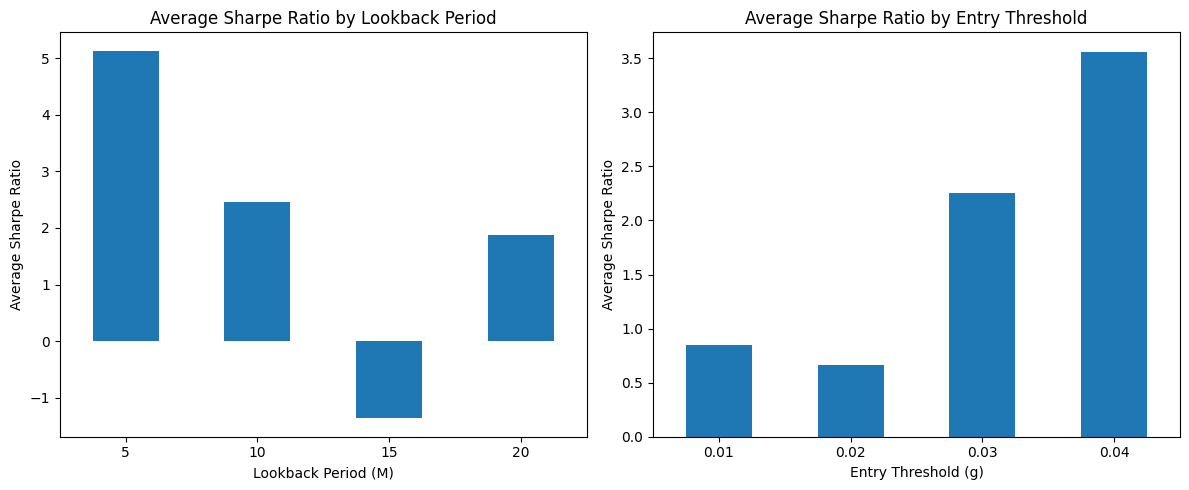

In [14]:
results = parameter_study(RTH, XRT, ff_factors, SVOL)
best_params = analyze_best_parameters(results)

best_row = best_params.iloc[0]

best_strategy = SpreadTradingStrategy(
    etf_x_data=RTH,
    etf_y_data=XRT,
    lookback_M=int(best_row['M']),  # Explicitly convert to integer
    entry_g=float(best_row['g']),
    exit_j=float(best_row['j']),
    stop_loss_s=float(best_row['s']),
    trade_cost_zeta=float(best_row['zeta'])
)

trades = best_strategy.run_strategy()


Looking at the top 5 parameter combinations, there are several interesting patterns and insights:

Lookback Period (M):


All top performing combinations use M = 5 days
This shorter lookback period suggests the strategy works best capturing quick mean-reversion opportunities between the ETFs


Entry Threshold (g):


All top combinations use g = 0.04 (4%)
This relatively high entry threshold indicates the strategy waits for significant divergence before entering positions
This helps filter out noise and likely reduces false signals


Exit Threshold (j):


All use j = 0.015 (1.5%)
The exit threshold is notably tighter than the entry threshold (1.5% vs 4%)
This suggests a quick profit-taking approach once the spread starts to normalize


Stop Loss (s):


The stop loss levels vary between 5-15% (0.05-0.15)
Interestingly, having different stop loss levels didn't significantly impact performance
This suggests the strategy rarely hits stop losses, which is positive


Trading Costs (zeta):


Most combinations work best with zero or very low trading costs (0.00000-0.00001)
This indicates the strategy might be sensitive to transaction costs

The overall performance is quite strong:

Sharpe ratios are consistently high (around 12.3-12.36)
Total PnL is substantial (around 1300-1304 units)
The results are very consistent across the top combinations


Fama-French Factor Exposures:
Mkt-RF: 0.329
SMB: 0.426
HML: -0.198


C:\Users\steph\AppData\Local\Temp\ipykernel_20468\1056826545.py:140: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_pnl = merged_data.groupby(svol_quintiles)['pnl'].mean()


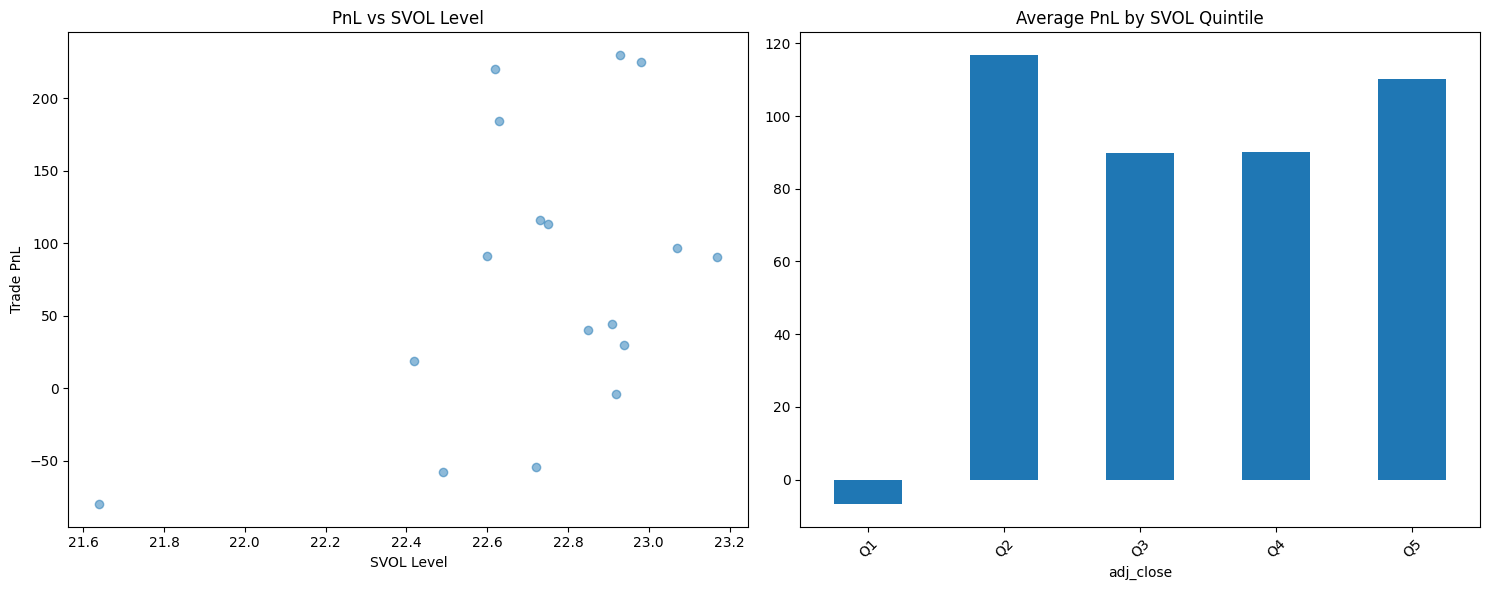

In [15]:
factor_exposures = analyze_factor_exposure(best_strategy, ff_factors)

print("\nFama-French Factor Exposures:")
for factor, corr in factor_exposures.items():
    print(f"{factor}: {corr:.3f}")

analyze_svol_relationship(best_strategy, SVOL)
plt.show()

Market Factor (Mkt-RF): 0.329


Moderately positive correlation with market returns
Suggests the strategy has some market exposure, but it's not very high
This level of market exposure is reasonable and indicates the strategy isn't just capturing market beta


Size Factor (SMB): 0.426


Strongest correlation among the three factors
Positive correlation indicates the strategy tends to perform better when small-cap stocks outperform large-cap stocks
This makes sense given retail ETFs might have varying exposures to different market capitalizations


Value Factor (HML): -0.198


Slight negative correlation with value factor
Suggests a small tilt toward growth over value stocks
The magnitude is relatively small, indicating this isn't a major driver of returns

PnL vs SVOL Level (Scatter Plot):


There's higher dispersion of PnL at higher SVOL levels (around 22.8-23.2)
The largest gains (around 200+ PnL) occur at higher SVOL levels
However, there are also some losses at higher SVOL levels, suggesting increased risk
The pattern suggests the strategy's returns become more volatile as market volatility increases


Average PnL by SVOL Quintile (Bar Chart):


Q1 (lowest volatility quintile) shows slightly negative average returns
Q2 shows the highest average PnL (around 115)
Q3 and Q4 show moderate positive returns (around 85-90)
Q5 (highest volatility quintile) shows strong returns (around 110)

Strategy tends to perform better in moderate to high volatility environments
